# Monitoreo de cicatrices de quema a través de imágenes satelitales para determinar el nivel de gravedad de la quema 
## Indice espectral NBR Analisis en GEE (Google Earth Engine)

### Indice Normalizado de Área Quemada (NBR)

El índice Normalizado de Área Quemada (NBR) es un índice diseñado para resaltar áreas quemadas en grandes zonas de incendio. La fórmula es similar a NDVI, excepto que combina el uso de longitudes de onda de infrarrojo cercano (NIR) e infrarrojo de onda corta (SWIR).

\begin{equation*}
NBR=\frac{NIR-SWIR}{NIR+SWIR}
\end{equation*}

\begin{equation*}
\left.
\begin{aligned}
NIR = \text{Infrarojo cercano}\\
SWIR = \text{Infrarojo de onda corta}
\end{aligned}
\right\}
\quad\text{Regiones del NBR}
\end{equation*}

Luego de realizar el análisis independiente del NBR (en cada una de las fechas) se realizará un análisis conjunto de las imágenes en las dos fechas ingresadas, y así tener un análisis adicional de la gravedad de quema basándose en ese rango de información

##  Instalación de paquetes o librerias
> **NOTA**: Las librerías solo la primera vez que se corre el código se instalan quitando el numeral para que funcionen los !pip install es importante correrlos por primera vez, pero si se importó el enviroment no hay necesidad de correr los !pip install

> **Nota importante**: una diferencia clave entre folium e ipyleaflet es que ipyleaflet se basa en ipywidgets y permite la comunicación bidireccional entre el front-end y el backend, lo que permite el uso del mapa para capturar las entradas del usuario, mientras que el folium está destinado a mostrar solo datos estáticos (fuente). Tenga en cuenta que Google Colab actualmente no es compatible con ipyleaflet (fuente). Por lo tanto, si está usando geemap con Google Colab, debe usar import geemap.eefolium. Si está utilizando geemap con Binder o un servidor local Jupyter, puede usar import geemap, que proporciona más funcionalidades para capturar la entrada del usuario (por ejemplo, hacer clic y mover el mouse).

Instale la API de Python de [Earth Engine](https://developers.google.com/earth-engine/python_install) y [geemap](https://github.com/giswqs/geemap). El paquete **geemap** Python se basa en los paquetes [ipyleaflet](https://github.com/jupyter-widgets/ipyleaflet) y [folium](https://github.com/python-visualization/folium) e implementa varios métodos para interactuar con las capas de datos de Earth Engine, como `Map.addLayer (), Map.setCenter () y Map.centerObject ()`. El siguiente script comprueba si el paquete geemap ha sido instalado. De lo contrario, instalará geemap, que instala automáticamente sus dependencias, incluidas earthengine-api, folium e ipyleaflet.

In [ ]:
# Importar paquete de las diferentes librerías, GEE (google Earth Engine), geemap, geopandas y pandas
#!pip install earthengine-api 
#!pip install geemap
#!pip install geopandas
#!pip install pandas
# hay imágenes que requieren que jupyter tenga mas memoria para procesar si es el caso corra una sola vez esta línea de código.
# jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000
import os
import geopandas as gpd
import geemap
import ee
import matplotlib.pyplot as plt
import datetime
import pandas as pd
# Esta línea de código va a solicitar en una ventana adicional el uso de earthengine con un correo personal o de Gmail usted debe aceptar a todo y continuar para q pueda hacer uso de la librería y de las imágenes
ee.Authenticate()
ee.Initialize()

## Filtrar zona estudio SHP

In [ ]:
# Cargar el shapefile usando GeoPandas y geemap
# Ejemplo de como se debe colocar manualmente la ruta -> nshp = gpd.read_file(handle_file_upload) nshp = gpd.read_file("C:/Users/ccami/Desktop/ENOS/algoritmo/datosfuenteparaalgoritmo/2019poligonoprueba.shp")
nshp = gpd.read_file("C:/Users/ccami/Desktop/ENOS/algoritmo/ejemploangelo.shp")
# Crea un GeoJSON para q se represente en GeoPandas por medio de un dataframe
zona_ee = geemap.gdf_to_ee(nshp)
#Si quiere ver el resultado de la visualización de zona_ee debe quitar el numeral para q imprima en pantalla el array
#print(zona_ee)
Map = geemap.Map(basemap='SATELLITE')
geometria = zona_ee.geometry()
Map.centerObject(geometria, 11)
Map.addLayer(zona_ee, {"color" : "00FF11"},name = "Zona estudio")
# Con esta línea de código se muestra en un visor la información cargada
Map

## Seleccion de imagenes
Se debe escoger una imagen inicial para poder realizar el análisis NBI, si es el caso puede modificar los parámetros si quiere visualizar más imágenes, por el momento tiene un filtro de 20% de nubosidad y el otro filtro es la fecha entre un rango.
### Imagen inicial

In [ ]:
# Coleccion de Sentinel-2 SR .filterDate('2019-08-20','2019-09-30')\.filterDate('2020-02-01','2020-04-30')\
Imagen_S2_RS_antes = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
          .filterDate('2021-12-01','2022-01-30')\
          .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',20)\
          .filterBounds(zona_ee)

In [ ]:
# Conteo de imagenes
count = Imagen_S2_RS_antes.size()
print("Cantidad de imagenes Imagen_S2_RS_antes:", count.getInfo())

In [ ]:
# se fabrica Lista de ID Imágenes y se convierte en tabla para mostrar al usuario
ID_Imagen_S2_RS_antes = Imagen_S2_RS_antes.reduceColumns(ee.Reducer.toList(),["system:index"]).get("list").getInfo()
#print(ID_S2)

# funcion para determinar la fecha coleccion imagen
def list_coll(coll):
    def func_ejv(im):
        return ee.String(ee.Image(im).date().format('YYYY/MM/dd')).slice(0)
    return coll.toList(coll.size(), 0).map(func_ejv)

# Lista de fechas de coleccion de imagenes
fecha = list_coll(Imagen_S2_RS_antes).getInfo()
#print(fecha)

# Imprimir la lista + Porcentaje Nubosidad
porcentaje_nube = Imagen_S2_RS_antes.reduceColumns(ee.Reducer.toList(),["CLOUDY_PIXEL_PERCENTAGE"]).get("list").getInfo()
#print(porcentaje_nube)

# Imprimir la lista MGRS_TILE
TILE = Imagen_S2_RS_antes.reduceColumns(ee.Reducer.toList(),["MGRS_TILE"]).get("list").getInfo()
#print(TILE)

# Crear un diccionario con las listas
dic = {"ID": ID_Imagen_S2_RS_antes, "Fecha": fecha,"Porcentaje Nube": porcentaje_nube, "TILE": TILE}

# Crear un DataFrame mediante el diccionario
df1 = pd.DataFrame(data = dic)
pd.set_option('display.max_rows', None)  # Muestra todas las filas
#pd.set_option('display.max_columns', None)  # Muestra todas las columnas
#pd.set_option('display.width', None)  # Ajusta el ancho de la pantalla
#pd.set_option('display.max_colwidth', None)  # Ajusta el ancho de las columnas
# las opciones anteriores se pueden momentariar o poner una sola ya que solo es para presentar mejor la tabla al usuario
print(df1)
print("Tipo de clase: ", type(dic))

Se selecciona la imagen manualmente del listado para poder probar varias imágenes solo debe cambiar el número y poder usar otra en el análisis

In [ ]:
# Importar imagen Sentinel-2 RS ID_Imagen_S2_RS_antes[11] y ID_Imagen_S2_RS_antes[6]
image_antes = ee.Image("COPERNICUS/S2_SR" + "/" + ID_Imagen_S2_RS_antes[3])
# Nombre de las bandas
print(image_antes.bandNames().getInfo())

# Crear nombre por bandas
bandas_RS = ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B11","B12"]

# Seleccionar imagenes por bandas
S2_img_RS_antes = image_antes.select(bandas_RS)

# Nombre de las bandas
S2_img_RS_antes.bandNames().getInfo()

# Consultar propiedades de los campos metadato
S2_img_RS_antes.propertyNames().getInfo()

# Simbologia de sentinel-2
viz_s2 = {
    'bands': ['B8A', 'B4', 'B3'],
    'min': 500,
    'max': 5000,
    'gamma': 1.2
}

# Visualizar la simbologia 
Map.addLayer(S2_img_RS_antes, viz_s2,name = "Sentinel2 S2_img_RS_antes")
Map.remove(zona_ee);
Map.addLayer(zona_ee, {"color" : "00FF11"},name = "Zona estudio")
Map

### Imagen secundaria

In [ ]:
# Coleccion de Sentinel-2 SR
Imagen_S2_RS_despues = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
          .filterDate('2024-01-01','2024-03-30')\
          .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',20)\
          .filterBounds(zona_ee)

In [ ]:
# Conteo de imagenes
count = Imagen_S2_RS_despues.size()
print("Cantidad de imagenes Imagen_S2_RS_despues:", count.getInfo())

In [ ]:
# Lista de ID Imagenes
ID_Imagen_S2_RS_despues = Imagen_S2_RS_despues.reduceColumns(ee.Reducer.toList(),["system:index"]).get("list").getInfo()
#print(ID_S2)

# funcion para determinar la fecha coleccion imagen
def list_coll(coll):
    def func_ejv(im):
        return ee.String(ee.Image(im).date().format('YYYY/MM/dd')).slice(0)
    return coll.toList(coll.size(), 0).map(func_ejv)

# Lista de fechas de coleccion de imagenes
fecha = list_coll(Imagen_S2_RS_despues).getInfo()
#print(fecha)

# Imprimir la lista + Porcentaje Nubosidad
porcentaje_nube = Imagen_S2_RS_despues.reduceColumns(ee.Reducer.toList(),["CLOUDY_PIXEL_PERCENTAGE"]).get("list").getInfo()
#print(porcentaje_nube)

# Imprimir la lista MGRS_TILE
TILE = Imagen_S2_RS_despues.reduceColumns(ee.Reducer.toList(),["MGRS_TILE"]).get("list").getInfo()
#print(TILE)

# Crear un diccionario con las listas
dic = {"ID": ID_Imagen_S2_RS_despues, "Fecha": fecha,"Porcentaje Nube": porcentaje_nube, "TILE": TILE}

# Crear un DataFrame mediante el diccionario
df1 = pd.DataFrame(data = dic)
print(df1)
print("Tipo de clase: ", type(dic))

Se selecciona la imagen manualmente del listado para poder probar varias imágenes solo debe cambiar el número y poder usar otra en el análisis

In [ ]:
# Importar imagen Sentinel-2 RS ID_Imagen_S2_RS_antes[90] y ID_Imagen_S2_RS_antes[89]
image_despues = ee.Image("COPERNICUS/S2_SR" + "/" + ID_Imagen_S2_RS_despues[0])
# Nombre de las bandas
print(image_despues.bandNames().getInfo())

# Crear nombre por bandas
bandas_RS = ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B11","B12"]

# Seleccionar imagenes por bandas
S2_img_RS_despues = image_despues.select(bandas_RS)

# Nombre de las bandas
S2_img_RS_despues.bandNames().getInfo()

# Consultar propiedades de los campos metadato
S2_img_RS_despues.propertyNames().getInfo()


# Visualizar ESCALADO 0 - 10000
Map.addLayer(S2_img_RS_despues, viz_s2,name = "Sentinel2 S2_img_RS_despues")
Map.remove(zona_ee);
Map.addLayer(zona_ee, {"color" : "00FF11"},name = "Zona estudio")
Map

## Determinar NBR
Desde este punto se realiza el calculo de NBR para cada una de las imágenes y se insertan en el visor para sus apreciaciones visuales, cabe resaltar que la simbología se puede cambiar y modificar la escala de colores que se esta usando

In [ ]:
# Funcion para NBR
def Calc_NBR(image):
    nbr = image.expression("float(nir - swir2)/(nir + swir2)", {
        'nir': image.select('B8A'),
        'swir2': image.select('B12')
    })
    return nbr.rename("NBR")

In [ ]:
# Calcular indices con la funcion de arriba
nbr_S2_antes = Calc_NBR(S2_img_RS_antes)
nbr_S2_despues = Calc_NBR(S2_img_RS_despues)


In [ ]:
# Simbologia de NBR
viz_nbr = {
    'palette': ["#66FF66","#FF99FF","#66FFFF","#FFFF99",
                "#FF9966","#FF6600","#FF0000"],
    'min': -0.4,
    'max': 0.8,
    'bands': "NBR"
}

In [ ]:
# Visualizar en esta parte se ponen los dos resultados en el visor
Map.addLayer(nbr_S2_antes, viz_nbr, name = "NBR antes")
Map.addLayer(nbr_S2_despues, viz_nbr, name = "NBR despues")
Map.remove(zona_ee);
Map.addLayer(zona_ee, {"color" : "00FF11"},name = "Zona estudio")
Map

## Determinar niveles de gravedad

El análisis de severidad de incendios es una de las posibilidades que tiene Google Earth Engine jugando con dos momentos históricos provenientes de imágenes de satélite. Este sencillo script para visualizar el momento anterior y posterior al incendio te ayudará a evaluar la severidad con la que el incendio ha arrasado el territorio.

Para visualizar un incendio, se trabaja con las bandas del Infrarrojo cercano y el Infrarrojo de onda corta. Cuando la vegetación sana es afectada por un incendio, la energía deja de ser reflejada y descienden bruscamente en las bandas del infrarrojo cercano (NIR) ascendiendo de manera elevada en el infrarrojo de onda corta (SWIR). Un comportamiento completamente opuesto al que ofrecen las masas vegetales en estado sano y que te ayudará a analizar valores de píxels entre dos momentos temporales.

Para analizar la severidad del incendio es necesario trabajar dos momentos temporales. Uno antes del incendio y otro después del incendio para las diferencias temporales. Es importante tener una referencia del momento anterior al incendio ya que no necesariamente el territorio tiene por qué estar en condiciones sanas y es posible que existieran cicatrites de algún incendio de manera previa.

In [ ]:
# Determinacion niveles de gravedad dNBR
dNBR = nbr_S2_antes.subtract(nbr_S2_despues)
#print(dNBR.getInfo())
#dNBR = nbr_S2_despues.subtract(nbr_S2_antes)

In [ ]:
# Definir la clasificación de NBR
clas_dnbr = ee.Image(0).where(dNBR.lt(-0.25), 1)\
                      .where(dNBR.gte(-0.25).And(dNBR.lt(-0.10)), 2)\
                      .where(dNBR.gte(-0.10).And(dNBR.lt(0.10)), 3)\
                      .where(dNBR.gte(0.10).And(dNBR.lt(0.27)), 4)\
                      .where(dNBR.gte(0.27).And(dNBR.lt(0.44)), 5)\
                      .where(dNBR.gte(0.44).And(dNBR.lt(0.66)), 6)\
                      .where(dNBR.gte(0.66), 7)\
                      .clip(zona_ee)\
                      .rename("dNBR")

# Calcular los valores mínimos y máximos
min_max = clas_dnbr.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=geometria,
    scale=20,
    maxPixels=1e8,  # Aumenta el límite de píxeles permitidos
    bestEffort=True  # Permite que Earth Engine ajuste la escala para cumplir con maxPixels
)

# Obtener los valores mínimos y máximos
min_value = int(min_max.get('dNBR_min').getInfo())
max_value = int(min_max.get('dNBR_max').getInfo())

# Imprimir los valores mínimos y máximos
# print(f"Valor mínimo de dNBR: {min_value}")
# print(f"Valor máximo de dNBR: {max_value}")

# Inicializar una lista para almacenar los resultados
conteo = []

# Iterar sobre cada valor en el rango de valores mínimos a máximos
for i in range(min_value, max_value + 1):
    # Contar los píxeles para el valor actual
    count = clas_dnbr.eq(i).updateMask(clas_dnbr.eq(i)).reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=geometria,
        scale=20,
        maxPixels=1e8,  # Aumenta el límite de píxeles permitidos
        bestEffort=True  # Permite que Earth Engine ajuste la escala para cumplir con maxPixels
    ).get('dNBR').getInfo()
    
    # Calcular hectáreas
    hectareas = count * 400 / 10000
    
    # Agregar el valor, el conteo, las hectáreas y el porcentaje a la lista
    conteo.append({
        'Valor': i,
        'Conteo': count,
        'Hectareas': hectareas
    })

# Crear un DataFrame con los resultados
df = pd.DataFrame(conteo)

# Calcular el total de píxeles
total_pixeles = df['Conteo'].sum()

# Agregar la columna de porcentaje
df['Porcentaje'] = (df['Conteo'] / total_pixeles) * 100

# Imprimir el DataFrame
print(df)

# Separa el resultado en 7 clases de severidad del incendio para crear tabla

# Crear una sumatoria para toda la imagen
thresholds = ee.Image([-0.50, -0.25, -0.10, 0.10, 0.27, 0.44, 0.66])
classified = dNBR.gte(thresholds).reduce('sum').toInt()
allpix = classified.updateMask(classified)
pixstats = allpix.reduceRegion(
    reducer = ee.Reducer.count(),
    geometry = geometria,
    scale = 20,
    maxPixels=1e8,  # Aumenta el límite de píxeles permitidos
    bestEffort=True  # Permite que Earth Engine ajuste la escala para cumplir con maxPixels
)
allpixels = ee.Number(pixstats.get('sum'))
allpixels.getInfo()

In [ ]:
# Funcion para sacar valores de tabla
def Calc_NBRtabla(cnr, name):
    singleMask = classified.updateMask(classified.eq(cnr))
    stats = allpix.reduceRegion(        
        reducer = ee.Reducer.count(),
        geometry = geometria,
        scale = 20,
        maxPixels=1e8,  # Aumenta el límite de píxeles permitidos
        bestEffort=True  # Permite que Earth Engine ajuste la escala para cumplir con maxPixels
    )
    pix = ee.Number(stats.get('sum'))
    hect = pix.multiply(400).divide(10000)
    perc = pix.divide(allpixels).multiply(10000).round().divide(100)
    return {
        'name': name,
        'pix': pix,
        'hect': hect,
        'perc': perc
    }

# Ejemplos de valores de entrada
cnrs = [-0.50, -0.25, -0.10, 0.10, 0.27, 0.44, 0.66]
names = ["Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6", "Class 7"]

# Inicializar listas para almacenar los resultados
names_list = []
pix_list = []
hect_list = []
perc_list = []

# Invocar la función para cada clase y almacenar los resultados en las listas
for cnr, name in zip(cnrs, names):
    result = Calc_NBRtabla(cnr, name)
    names_list.append(result['name'])
    pix_list.append(result['pix'].getInfo())
    hect_list.append(result['hect'].getInfo())
    perc_list.append(result['perc'].getInfo())

# Crear un diccionario con las listas
data = {
    'Name': names_list,
    'Pixels': pix_list,
    'Hectares': hect_list,
    'Percentage': perc_list
}

# Crear un DataFrame mediante el diccionario
df = pd.DataFrame(data)

# Mostrar el DataFrame
#print(df)

In [ ]:
# Nombre de la banda clasificado
# clas_dnbr.bandNames().getInfo()
dNBR.getInfo()

In [ ]:
# Simbologia de Clase NBR
viz_nbr_clas = {
    'palette': ["#1a9850","#91cf60","#d9ef8b","#ffffbf",
                "#fee08b","#fc8d59","#d73027"],
    'min': 1,
    'max': 7,
    'bands': "dNBR"
}


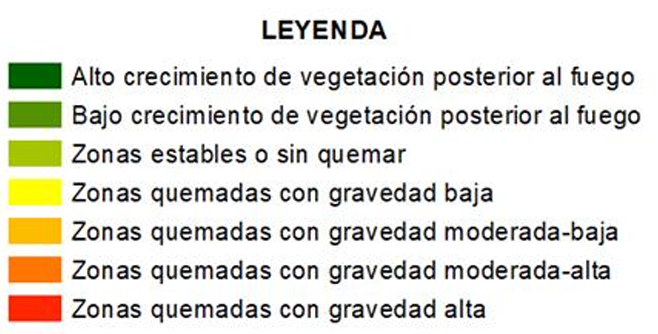

In [ ]:
# Visualizar en el visor la información generada
Map.addLayer(clas_dnbr, viz_nbr_clas, name = "NBR clase")
Map.remove(zona_ee);
Map.addLayer(zona_ee, {"color" : "00FF11"},name = "Zona estudio")
Map

In [ ]:
# Visualizar en pantalla el area en Hectareas del poligono generado en pixeles puede variar un poco con el area del poligon del shp ya que hay pixeles que pueden caer por dentro o por fuera de la información vectorial 
area_ha = geometria.area().divide(10000)
print("Area Poligono de pixeles: ", round(area_ha.getInfo(),3),"Ha")

## Exportar Imagen
 Para finalizar el Algoritmo se genera un archivo exportable de la imagen resultado, es importante que si se quiere exportar las imágenes con las que se realizó el estudio puede modificar las lineas siguientes para poder bajar la información.

In [ ]:
os.getcwd()

In [ ]:
ruta_archivos = r"C:\Users\ccami\Desktop\ENOS\algoritmo\Veredas_68_priorizadas\poligonos\50_META"
os.chdir(ruta_archivos) # Cambiar ruta trabajo
os.getcwd() # Consultar ruta trabajo

In [ ]:
# Exportar imagen directorio
#geemap.ee_export_image(clas_dnbr, filename="50568_1_NvGv.tif", scale=20, region=geometria, file_per_band=False)

In [ ]:
# Exportar en google drive
#geemap.ee_export_image_to_drive(clas_dnbr, description='S2_NvGv', folder='GEE_Python', region=geometria, scale=30)